Test out supervised and unsupervised metrics for the phase mapping problem

In [7]:
import data_grid
import numpy as np

from xrdc import xrdutils as xdu
from xrdc import geometry as geo
from xrdc import simulation as sim
from xrdc import visualization as vis
from xrdc import metrics
from xrdc import grid_data as gd

from siamese_xrd import train, utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ternary

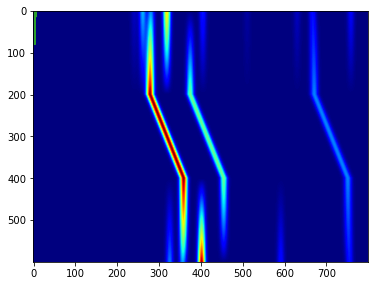

In [312]:
path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

dgrid = data_grid.DataGrid(path, """TiNiSn_500C_Y20190218_14x14_t60_(?P<num>.*?)_bkgdSub_1D.csv""",range=None)

X=dgrid.get_data_array()
q=dgrid.data[1][:,0]

N = X.shape[0]

coords = np.array([np.array(dgrid.coord(ii+1)) for ii in range(N)])

CoNi = pd.read_json("../xrdc/inputs/mp-1226076_xrd_Cu_CoNi.json", lines=True)
Co = pd.read_json("../xrdc/inputs/mp-1183710_xrd_Cu_Co.json", lines=True)
Ni = pd.read_json("../xrdc/inputs/mp-10257_xrd_Cu_Ni.json", lines=True)
Sn = pd.read_json("../xrdc/inputs/mp-117_xrd_Cu_Sn.json", lines = True)

_, _, ib, qb = xdu.plt_pat(CoNi);
qqa, iia, ia, qa = xdu.plt_pat(Co);
qqc, iic, ic, qc = xdu.plt_pat(Ni);

sigma = .03
N = 200
shift_size = .2

Co_to_CoNi_shift = sim.transition(-shift_size, -shift_size, (qa, ia), (qb, ib), N, sigma, scale_type = 'shift')

CoNi_to_CoNi_shift = sim.transition(-shift_size, shift_size, (qb, ib), (qb, ib), N, sigma, scale_type = 'shift')

CoNi_to_Ni_shift = sim.transition(shift_size, shift_size, (qb, ib), (qc, ic), N, sigma, scale_type = 'shift')

X = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

We pattern simulated datasets off of Suchi's library wafers

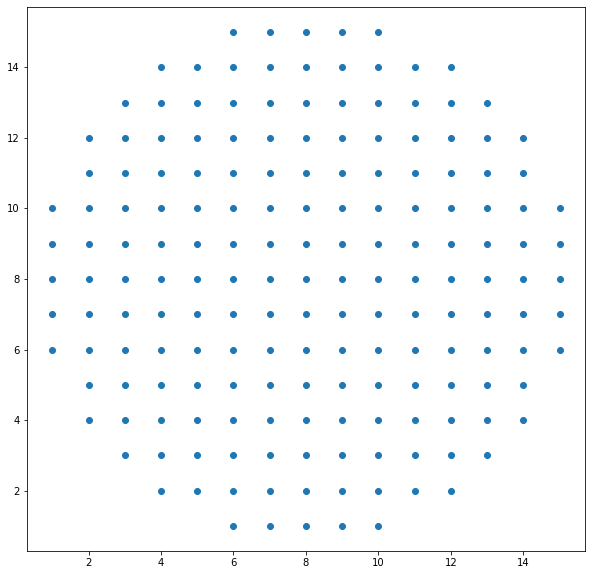

In [283]:
plt.scatter(waferx, wafery)

In [99]:
from importlib import reload
reload(geo)

<module 'xrdc.geometry' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/geometry.py'>

this should be balanced: 55 55 67


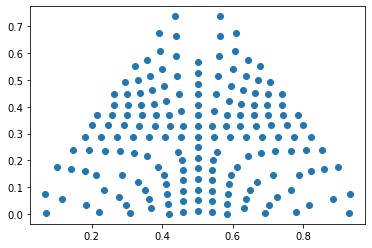

In [102]:
plt.scatter(sx, sy)

In [138]:
waferx, wafery = coords.T
R = np.sqrt((waferx - waferx.mean())**2 + (wafery - wafery.mean())**2).max() + .1

xx, yy = (waferx - waferx.mean()) / R, (wafery - wafery.mean()) / R
sx, sy = geo.circle_to_simplex(waferx, wafery)
xx, yy, zz = ternary.helpers.planar_to_coordinates(np.vstack((sx, sy)), 1)

def composition_to_patterns(*compositions, single_phase_threshold = .5):
    xx, yy, zz = compositions #compositions[:, 0], compositions[:, 1], compositions[:, 2]

    peakshift_val = (-xx + zz)
    # index into the array of 200 different-peak shift patterns
    peakshift_idx = ((N * peakshift_val).astype(int) + (N)) // 2

    s1_pat = Co_to_CoNi_shift[0]
    s3_pat = CoNi_to_Ni_shift[-1]

    single_phase_mask = (zz > single_phase_threshold)
    s1_weighted = (xx[:, None] * s1_pat) * (~single_phase_mask)[:, None]
    #s2_weighted = yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]
    s2_weighted = (single_phase_mask)[:, None] * CoNi_to_CoNi_shift[peakshift_idx]\
            + (yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]) * (~single_phase_mask)[:, None]
    s3_weighted = (zz[:, None] * s3_pat) * (~single_phase_mask)[:, None]



    total = s1_weighted + s2_weighted + s3_weighted
    assert np.isclose(total.mean(axis = 1), 1).all()
    return s1_weighted, s2_weighted, s3_weighted, total

In [377]:
s1_weighted, s2_weighted, s3_weighted, X = composition_to_patterns(xx, yy, zz)

In [439]:
np.unique(YY_test[(yy > .5)])

array([ 0,  3,  7,  9, 11, 16, 18, 21], dtype=int32)

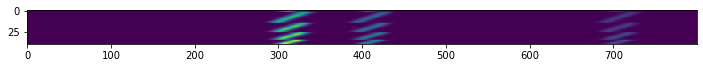

In [428]:
plt.imshow(s2_weighted[yy > .5])

In [378]:
#total.sum(axis = 1)
X.shape

(177, 800)

In [384]:
Y_test = (yy > .5).astype(int)

In [271]:
# peakshift_val = (-xx + zz)
# # index into the array of 200 different-peak shift patterns
# peakshift_idx = ((N * peakshift_val).astype(int) + (N)) // 2

# s1_pat = Co_to_CoNi_shift[0]
# s3_pat = CoNi_to_Ni_shift[-1]

# single_phase_mask = (zz > single_phase_threshold)
# s1_weighted = (xx[:, None] * s1_pat) * (~single_phase_mask)[:, None]
# #s2_weighted = yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]
# s2_weighted = (single_phase_mask)[:, None] * CoNi_to_CoNi_shift[peakshift_idx]\
#         + (yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]) * (~single_phase_mask)[:, None]
# s3_weighted = (zz[:, None] * s3_pat) * (~single_phase_mask)[:, None]



# total = s1_weighted + s2_weighted + s3_weighted
# assert np.isclose(total.mean(axis = 1), 1).all()

In [284]:
single_phase_mask.sum()

42

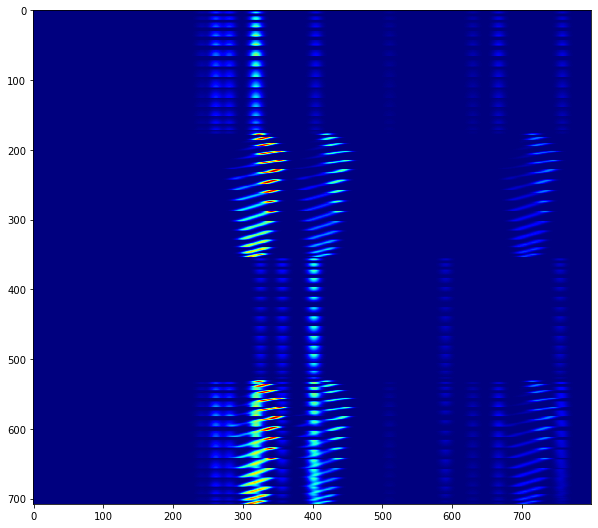

In [276]:
plt.rcParams["figure.figsize"]=(10, 10)

plt.imshow(np.vstack((s1_weighted, s2_weighted, s3_weighted, total)), cmap = 'jet')

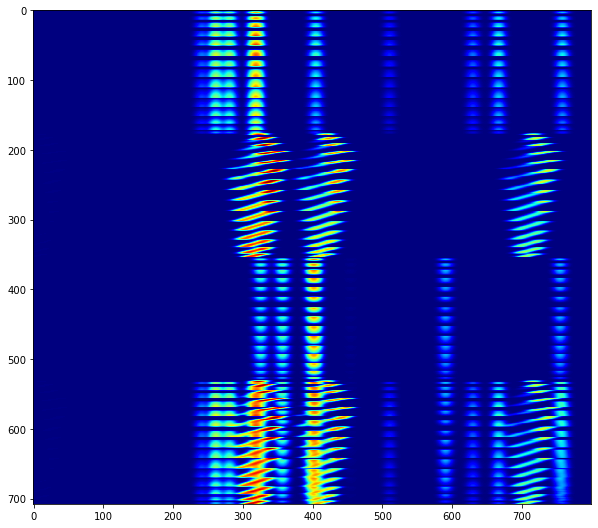

In [278]:
plt.rcParams["figure.figsize"]=(10, 10)

plt.imshow(np.log(1 + np.vstack((s1_weighted, s2_weighted, s3_weighted, total))), cmap = 'jet')

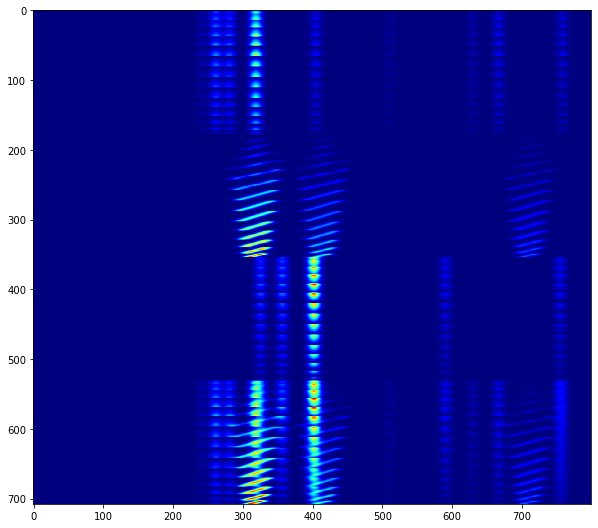

In [252]:
plt.rcParams["figure.figsize"]=(10, 10)

plt.imshow(np.vstack((s1_weighted, s2_weighted, s3_weighted, total)), cmap = 'jet')

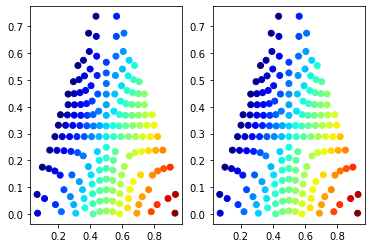

In [245]:
plt.subplot(1, 2, 1)
plt.scatter(sx, sy, c = s1_weighted.sum(axis = 1), cmap = 'jet')
plt.subplot(1, 2, 2)
plt.scatter(sx, sy, c = xx, cmap = 'jet')

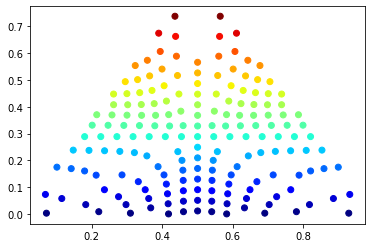

In [246]:
plt.scatter(sx, sy, c = s2_weighted.sum(axis = 1), cmap = 'jet')

In [285]:
# plt.plot(peakshift_idx[np.argsort(peakshift_idx)])
# plt.plot(s1_idx[np.argsort(s1_idx)])

Dataset definition

(177, 800)


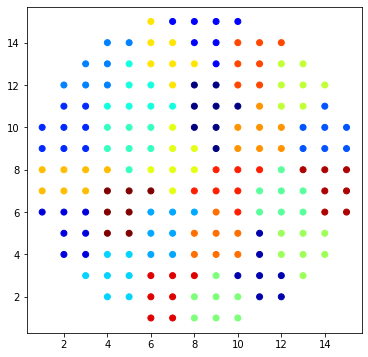

In [363]:
# plt.rcParams["figure.figsize"]=(6, 6)

# X=dgrid.get_data_array()
# q=dgrid.data[1][:,0]

# N = X.shape[0]
# Y = gd.group_by_coord(coords, 7)

# plt.scatter(*(coords.T), c = Y, cmap = 'jet')

# prefix = 'CoNi_sim_wafer'
# XX, YY = xdu.augment(X, Y, -.25, .25, q, N = 40, scale_type = 'shift')

In [385]:
def gen_data(dataGrid, scale_type, X, q, scale_min = -.25, scale_max = .25, N_augment = 20, N_neighbor = 6, augment = True, **plot_args):
    """
    Group XRD patterns from a wafer library by neighborhood
    """
    # TODO hack, come back and add support for simulation data to the DataGrid class
#     X=dataGrid.get_data_array()
#     q=dataGrid.data[1][:,0]

    N = X.shape[0]

    coords = np.array([np.array(dgrid.coord(ii+1)) for ii in range(N)])

    Y = gd.group_by_coord(coords, N_neighbor)

    plt.scatter(*(coords.T), c = Y, **plot_args)
    if augment:
        X, Y = xdu.augment(X, Y, scale_min, scale_max, q, N = N_augment, scale_type = scale_type)
    X, Y = xdu.standardize_input(X, Y)
    return X, Y

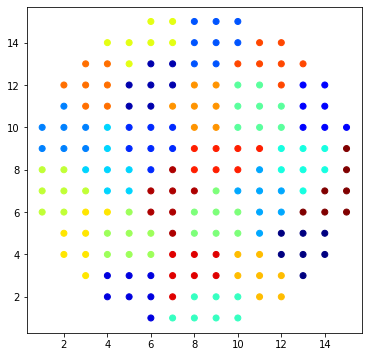

In [408]:
XX, YY = gen_data(dgrid, 'shift', X, q, scale_min = -.5, scale_max = .5, N_neighbor = 7, augment = True, cmap = 'jet')

TODO: try binary labels as YY_test

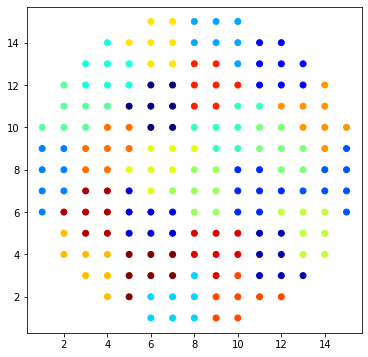

In [409]:
XX_test, YY_test = gen_data(dgrid, 'shift', X, q, N_neighbor = 7, augment = False, cmap = 'jet')

In [394]:
prefix = 'CoNi_sim_wafer'

In [365]:
#XX, YY = xdu.standardize_input(XX, YY)
#X, Y = xdu.standardize_input(X, Y)

In [396]:
xdu.write_train_test("data/{}/".format(prefix), XX, YY,
                 XX_test,\
                 YY_test)

In [368]:
XX.shape, YY.shape

((7080, 150), (7080, 1, 1))

In [398]:
YY.max(), Y.max()

(24, 1)

In [410]:
epochs = 200
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix, epochs), "data/{}/test".format(prefix), name = prefix,
          n_classes = YY.max() + 1, epochs = epochs)

  0%|          | 0/22200 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 22200/22200 [04:58<00:00, 74.36it/s, epoch=199, train_loss=0.0577, val_loss=0.0601] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_sim_wafer-*


In [400]:
#rm -r ./tmp/siamese-constrastive_1d-XRD-CoNi_sim_wafer-gif

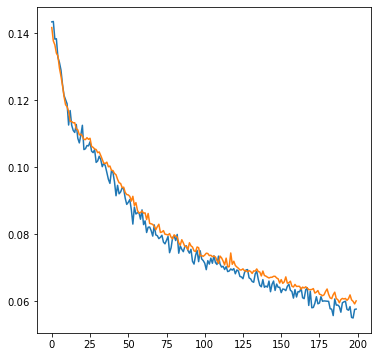

In [411]:
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

In [354]:
rm -r ./tmp/siamese-constrastive_1d-XRD-CoNi_sim_wafer-gif

Text(0.5, 1.0, "CoNi: 'single phase' points")

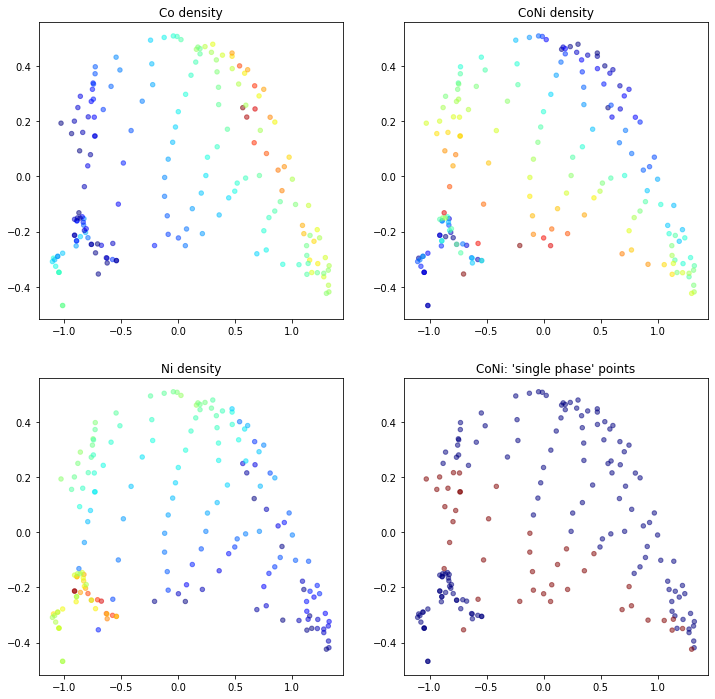

In [425]:
plt.rcParams["figure.figsize"]=(12, 12)

pca, Xpca = vis.xrd_to_pca_original(net, original_test_loader, utils.get_embedding)

plt.subplot(2, 2, 1)
plt.scatter(*(Xpca.T) , cmap='jet', c = xx, alpha = .5, s = 20)
plt.title("Co density")

plt.subplot(2, 2, 2)
plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)
plt.title("CoNi density")

plt.subplot(2, 2, 3)
plt.scatter(*(Xpca.T) , cmap='jet', c = zz, alpha = .5, s = 20)
plt.title("Ni density")
#plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)

plt.subplot(2, 2, 4)
plt.scatter(*(Xpca.T) , c = (yy > .5), cmap='jet', alpha = .5, s = 20)
plt.title("CoNi: \'single phase\' points")


  0%|          | 0/22200 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 22200/22200 [05:25<00:00, 68.15it/s, epoch=199, train_loss=0.115, val_loss=0.113] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_sim_wafer_aug11-*


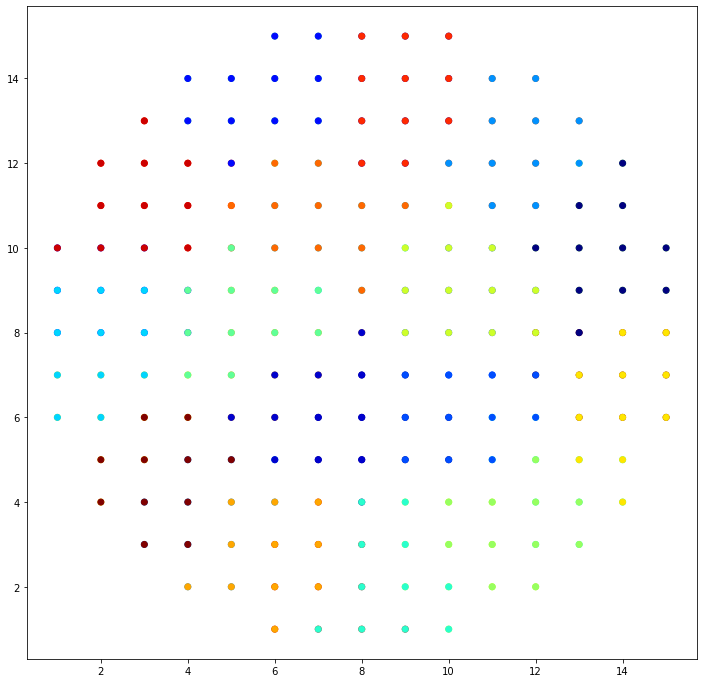

In [440]:
prefix = 'CoNi_sim_wafer_aug11'


XX, YY = gen_data(dgrid, 'shift', X, q, scale_min = -.5, scale_max = .5, N_neighbor = 11, augment = True, cmap = 'jet')
XX_test, YY_test = gen_data(dgrid, 'shift', X, q, N_neighbor = 11, augment = False, cmap = 'jet')

xdu.write_train_test("data/{}/".format(prefix), XX, YY,
                 XX_test,\
                 YY_test)

epochs = 200
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix, epochs), "data/{}/test".format(prefix), name = prefix,
          n_classes = YY.max() + 1, epochs = epochs)

Text(0.5, 1.0, "CoNi: 'single phase' points")

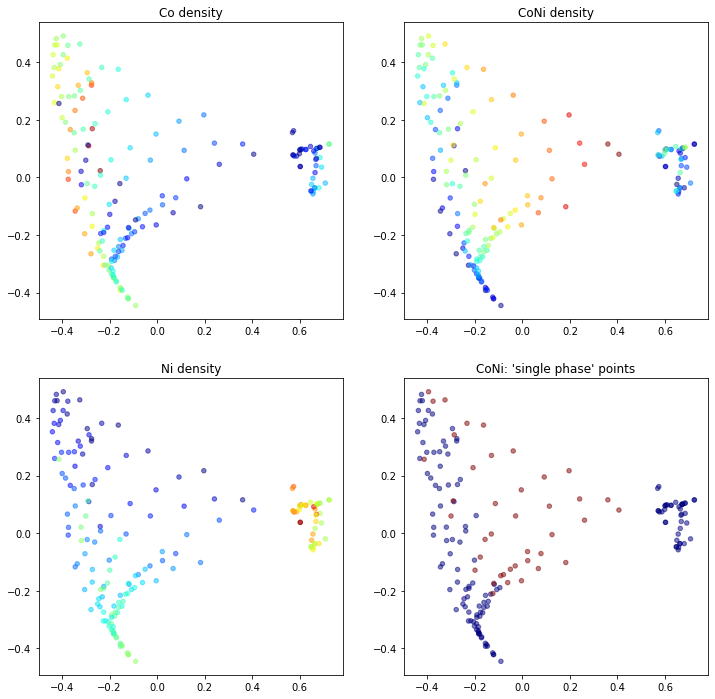

In [441]:
plt.rcParams["figure.figsize"]=(12, 12)

pca, Xpca = vis.xrd_to_pca_original(net, original_test_loader, utils.get_embedding)

plt.subplot(2, 2, 1)
plt.scatter(*(Xpca.T) , cmap='jet', c = xx, alpha = .5, s = 20)
plt.title("Co density")

plt.subplot(2, 2, 2)
plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)
plt.title("CoNi density")

plt.subplot(2, 2, 3)
plt.scatter(*(Xpca.T) , cmap='jet', c = zz, alpha = .5, s = 20)
plt.title("Ni density")
#plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)

plt.subplot(2, 2, 4)
plt.scatter(*(Xpca.T) , c = (yy > .5), cmap='jet', alpha = .5, s = 20)
plt.title("CoNi: \'single phase\' points")


  0%|          | 0/22200 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 22200/22200 [05:03<00:00, 73.06it/s, epoch=199, train_loss=0.115, val_loss=0.113] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_sim_wafer_aug15-*


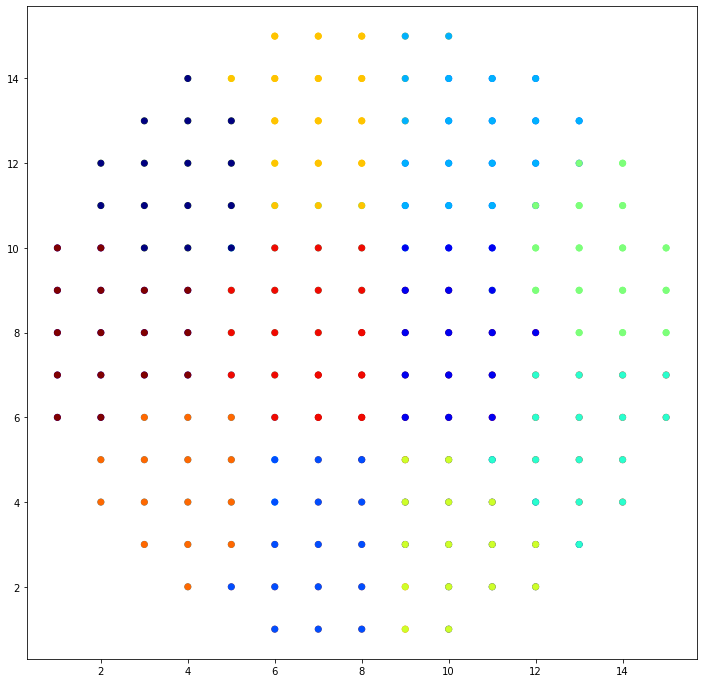

In [442]:
prefix = 'CoNi_sim_wafer_aug15'


XX, YY = gen_data(dgrid, 'shift', X, q, scale_min = -.5, scale_max = .5, N_neighbor = 15, augment = True, cmap = 'jet')
XX_test, YY_test = gen_data(dgrid, 'shift', X, q, N_neighbor = 15, augment = False, cmap = 'jet')

xdu.write_train_test("data/{}/".format(prefix), XX, YY,
                 XX_test,\
                 YY_test)

epochs = 200
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix, epochs), "data/{}/test".format(prefix), name = prefix,
          n_classes = YY.max() + 1, epochs = epochs)

Text(0.5, 1.0, "CoNi: 'single phase' points")

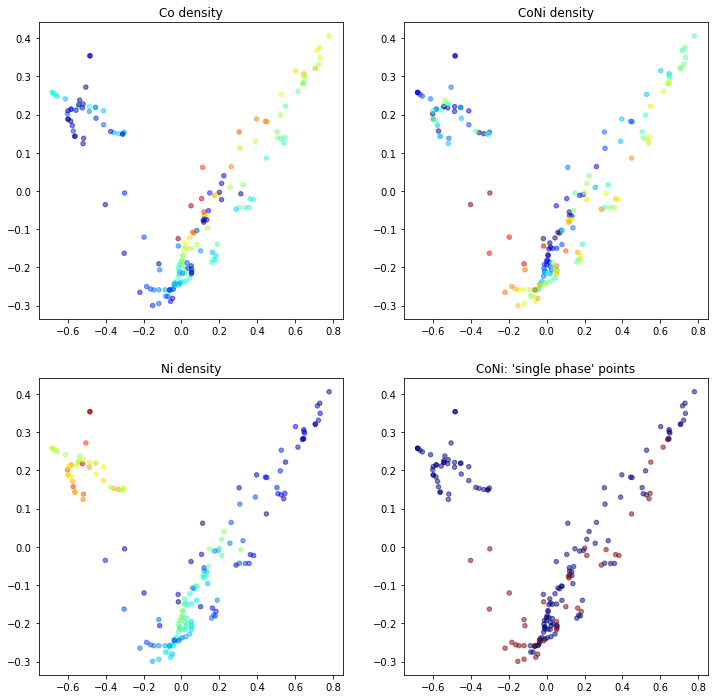

In [443]:
plt.rcParams["figure.figsize"]=(12, 12)

pca, Xpca = vis.xrd_to_pca_original(net, original_test_loader, utils.get_embedding)

plt.subplot(2, 2, 1)
plt.scatter(*(Xpca.T) , cmap='jet', c = xx, alpha = .5, s = 20)
plt.title("Co density")

plt.subplot(2, 2, 2)
plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)
plt.title("CoNi density")

plt.subplot(2, 2, 3)
plt.scatter(*(Xpca.T) , cmap='jet', c = zz, alpha = .5, s = 20)
plt.title("Ni density")
#plt.scatter(*(Xpca.T) , cmap='jet', c = yy, alpha = .5, s = 20)

plt.subplot(2, 2, 4)
plt.scatter(*(Xpca.T) , c = (yy > .5), cmap='jet', alpha = .5, s = 20)
plt.title("CoNi: \'single phase\' points")
